API Call example:

In [103]:
# import requests
# from dotenv import load_dotenv
# import os

# load_dotenv()

# key = os.getenv('API_KEY')
# email = os.getenv('EMAIL')

# r = requests.get(f"https://aqs.epa.gov/data/api/annualData/byState?email={email}&key={key}&bdate=20160101&edate=20160229&param=81102,42101&state=37")

Assemble and save a csv file containing all counties' annual AQI data from 1980 to 2025 from pre-generated data files available from the EPA (https://aqs.epa.gov/aqsweb/airdata/download_files.html).
 
 One should note that the documentation (https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_introduction) provided for these pre-generated data files is incorrect, and the information is instead for datasets returned from the AQS API. 

(Only needs to be run once, but preserved as a comment for reference)

In [104]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk 

# path = "Datasets"
# files = glob.glob(path + "/*.csv")

# annual_aqi_bycounty_df = pd.DataFrame()
# content = []

# for filename in files:
#     df = pd.read_csv(filename, index_col=None)
#     content.append(df)

# annual_aqi_bycounty_df = pd.concat(content)

# annual_aqi_bycounty_df.to_csv('./Datasets/all_years_aqi_by_county.csv', encoding='utf-8', index=False)

Use the created all_years_aqi_by_county.csv:

Select a subset of the data for experimenting / double-checking values.

In [105]:
all_years_aqi_by_county_df = pd.read_csv('./Datasets/all_years_aqi_by_county.csv')

all_years_aqi_by_county_df.head()

king_county_aqi_df = all_years_aqi_by_county_df[(all_years_aqi_by_county_df["State"] == "Washington") & (all_years_aqi_by_county_df["County"] == "King")]

print(king_county_aqi_df)
print(king_county_aqi_df.size)

            State County  Year  Days with AQI  Good Days  Moderate Days  \
428    Washington   King  1980            366         82            248   
916    Washington   King  1981            365         69            240   
1403   Washington   King  1982            365         78            205   
1896   Washington   King  1983            365         89            257   
2373   Washington   King  1984            366        128            232   
2911   Washington   King  1985            365        138            199   
3480   Washington   King  1986            365        115            226   
4094   Washington   King  1987            365        124            226   
4776   Washington   King  1988            366        202            154   
5515   Washington   King  1989            365        207            147   
6347   Washington   King  1990            365        211            136   
7219   Washington   King  1991            365        216            142   
8126   Washington   King 

Index Values (from Research/assumptions):

Further Reference for interpreting AQI values: https://www.airnow.gov/aqi/aqi-basics/using-air-quality-index/

    - State (String): Name of State
    - County (String): Name of County
    - Days with AQI (Int): Number of data points (days) in the annual summary for that county in that year
    - Good Days, Moderate Days, Unhealthy for Sensitive Groups Days, Unhealthy Days, Very Unhealthy Days, Hazardous Days (Int): Reference https://www.airnow.gov/aqi/aqi-basics/, number of days for that county in that year with an AQI index corresponding to that category
    - Max AQI (Int): Highest AQI value for that county in that year
    - 90th Percentile AQI (Int): 90th Percentile AQI value for that county in that year
    - Median AQI (Int): Median AQI value for that county in that year
    - Days CO, Days NO2, Days Ozone, Days PM2.5, Days PM10 (Int): The number of days that year that surpass EPA standards for Criteria Air Pollutants (Carbon Monoxide, Nitrogen Dioxide, Ozone, Particulate Matter 2.5 micrometers and smaller, Particulate Matter 10 micrometers and smaller, respectively)


Basic checks to ensure data is sensible / available:

In [106]:
# No duplicates within State, County, Year (i.e, every entry can be uniquely identified using those)
check_dupes = pd.DataFrame()
check_dupes = check_dupes[all_years_aqi_by_county_df.duplicated(subset=["State", "County", "Year"])]
print(check_dupes)

# Days with AQI: 
# All values within appropriate range; 1-366 (Leap Years)
days_freq = pd.crosstab(all_years_aqi_by_county_df["Days with AQI"], "Days with AQI")
print(days_freq)


Empty DataFrame
Columns: []
Index: []
col_0          Days with AQI
Days with AQI               
1                         11
2                         11
3                          9
4                         12
5                         21
...                      ...
362                      921
363                     1159
364                     1579
365                     9870
366                     3335

[366 rows x 1 columns]


C:\Users\sophi\AppData\Local\Temp\ipykernel_47724\2963362032.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  check_dupes = check_dupes[all_years_aqi_by_county_df.duplicated(subset=["State", "County", "Year"])]


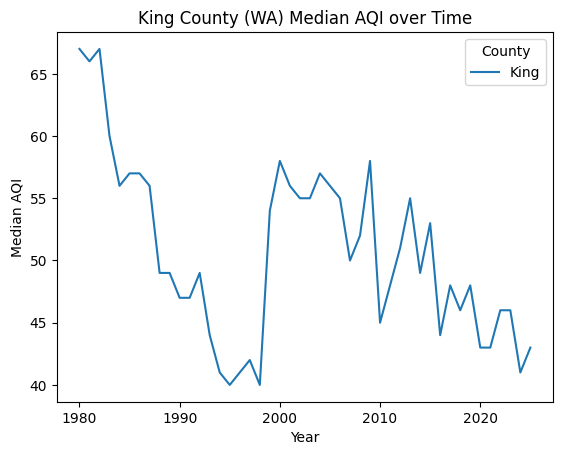

In [107]:
sns.lineplot(data=king_county_aqi_df, x='Year', y='Median AQI', hue="County")
plt.title("King County (WA) Median AQI over Time")
plt.show()

Baseline Max AQI predictor using all values:

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

dataset = all_years_aqi_by_county_df

dataset["CountyState"] = dataset["County"] + ", " + dataset["State"]
dataset = dataset.drop(columns=["County", "State"])

# Remove predictor from features
features = list(dataset.columns)

predictor = "Max AQI"
features =  list(set(features) - set(predictor))

predictor_df = all_years_aqi_by_county_df[predictor]
features_df = all_years_aqi_by_county_df[features]

le = LabelEncoder()
features_df["CountyState"] = le.fit_transform(features_df["CountyState"])

train_feat, test_feat, train_pred, test_pred = train_test_split(features_df, predictor_df, test_size=.2, random_state=123)

In [154]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

# Fit model
regression = LinearRegression().fit(train_feat, train_pred)

# RMSE
print(root_mean_squared_error(test_pred, regression.predict(test_feat)))

1.3069972425778287e-13
